# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - X_train_title_bow
                - X_train_title_vocab_bow
                - X_train_title_dist_bow
                - X_train_w_bow
                - X_train_w_vocab_bow
                - X_train_w_dist_bow
                - X_train_w_2gram_bow
                - X_train_w_2gram_vocab_bow
                - X_train_w_2gram_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                - y_train_0p1_bow
                - y_train_0p1vocab_bow
                - y_train_0p1dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                - X_train_tfidf
                - X_train_vocab_tfidf
                - X_train_dist_tfidf
                - X_train_title_tfidf
                - X_train_title_vocab_tfidf
                - X_train_title_dist_tfidf
                - X_train_w_tfidf
                - X_train_w_vocab_tfidf
                - X_train_w_dist_tfidf
                - X_train_w_2gram_tfidf
                - X_train_w_2gram_vocab_tfidf
                - X_train_w_2gram_dist_tfidf
                
7. Cleaning de données test
    - Arrays générés :
        - X_test_w_tfidf
        - X_test_w_vocab_tfidf
        - X_test_w_dist_tfidf
        - y_test_0p1_bow
        - y_test_0p1_vocab_bow
        - y_test_0p1_dist_bow      

# Chargement de bibliothéques

In [2]:
# Import the libraries

# Library for saving objects (vectorizers & models)
import joblib

# General libraries for data treatment
import numpy as np
import pandas as pd
import random
from pandas import Series, DataFrame
from sklearn import model_selection

# Libraries for text treatment
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from bs4 import BeautifulSoup 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries for dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# The library to allow the time mesure
import logging

# Libraries for data visualisation
from IPython.core.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

## Echantillon de données train / test

Les données était récupérées de stack overflow à l'aide de code suivant :

select top 50000 id, tags, title, body from posts where year(CreationDate)=2019 
and tags is not null and body is not null and title is not null
order by id

Nous avons récupéré les données les plus récentes. Nous souhaitons avoir des données sans manquantes. Afin de pouvoir travailler sans grosses limitations au niveau de calculs, nous travaillons sur un échantillon de 50 000 texts. 

In [40]:
data_load = pd.read_csv(
    'Data/Data2019_part1.csv', sep=',')

In [42]:
data_load.shape

(50000, 4)

In [43]:
data_load.head()

,id,tags,title,body
0,53992215,<java><executorservice><java-threads>,Using a ScheduledExecutorService to run a task...,<p>I am working on a program that will read da...
1,53992219,<c++><qt><qt5><qtstylesheets><qpushbutton>,How to programmatically change style sheet of ...,<p>I have so many buttons on a dialog and I wa...
2,53992220,<.htaccess>,Trying to put website into Maintenance Mode (3...,<p>I'm trying to put my webpage into Maintenan...
3,53992221,<node.js><lambda>,Node.js Lambda Async return Undefined,<p>Simple call to ec2 Describing Security grou...
4,53992223,<python><python-3.x><list><class><printing>,Unable to print a class list attribute using i...,<p>I am designing a deck class that has <stron...


In [44]:
any(data_load.duplicated())

False

Nous n'avons pas de doublons dans les données. Nous pouvons supprimer variable id qui n'est pas utile pour les prochaines traitements.

In [45]:
data_load.drop(['id'], axis=1, inplace=True)

## Echantillon pour créer modèle word2vect

Etant donné que nous souhaitons utiliser un modèle word2vect dans la second partie du projet et étant donné que les modèles disponibles sur google ne correspondent pas à notre dictionnaire spécialisé dans l'informatique, nous allons créer notre propre modèle de word2vect. L'algorithme fonctionne bien sur des données de grande taille. Nous allons donc utiliser un échantillon plus grand, de taille 500 000 texts afin de créer notre propre word2vect.

Les données ont été téléchargées de Stack Overflow dans 10 fichiers distincts. Nous allons donc merger les données pour avoir une base unifiée. 

In [8]:
data_w2v = data_load.copy()

for i in range(2,11):

    url = 'Data/Data2019_part' + str(i) + '.csv'

    data = pd.read_csv(url, sep=',')
    
    data.drop(['id'], axis=1, inplace=True)
    
    data_w2v = pd.concat([data_w2v, data], ignore_index=True)

In [9]:
data_w2v.shape

(500000, 3)

In [10]:
any(data_w2v.duplicated())

False

Les données contiennent 500 000 texts sans doublons.

## Création d'un jeu de données test

Notre variable cible est la variable tags. Nous avons deux variables texte qui nous permettrons estimer le tag : variables title et body. Nous allons séparer 30 % de données qui seront utilisées plus tard afin de tester les modèles :

In [46]:
target = data_load['tags']

In [47]:
data=data_load.drop(['tags'], axis=1)

In [48]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.3, random_state=1)

In [49]:
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 35000 observations et 2 features.
Le vecteur y_train contient 35000 observations.
Le jeu de données X_test contient 15000 observations et 2 features.
Le vecteur y_test contient 15000 observations.


Exporter les jeux de données en .csv

In [50]:
X_train.to_csv('Data/X_train.csv', sep='\t')
X_test.to_csv('Data/X_test.csv', sep='\t')
y_train.to_csv('Data/y_train.csv', sep='\t', header=False)
y_test.to_csv('Data/y_test.csv', sep='\t', header=False)

# Data cleaning 

## Tester les fonctions sur un exemple de features

Exemple de corps d'un post:

In [200]:
X_train.head()

,title,body
8950,recode/replace multiple values in a shared dat...,"<p>I hope I haven't missed it, but I haven't b..."
38421,Table in python,<p>In python I tried to make table like this</...
19363,TypeScript and JSON with list of objects in ob...,<p>I have a question. Why Typescript with Angu...
30157,Display the wordpress taxonomy image into fron...,<p>Trying to display the taxonomy images into ...
14294,Get feature names for dataframe.corr,<p>I am using the cancer data set from sklearn...


In [201]:
print(X_train['body'][0])

<p>I am working on a program that will read data from a data source, and publish that data as it is read. I have a reader and a writer, the reader spawns several threads to read all the data it needs to read, puts the data into a queue, and the writer reads the data from the queue an publishes it.</p>

<p>I have a controller for my readers and a controller for my writers. The controllers implement the <code>Callable</code> interface, but could implement the <code>Runnable</code> interface as my call return is <code>Void</code>.</p>

<p>I want to use an executor to run the two controllers. The reader controller will need to be invoked every X minutes (and X is greater than the time it takes the controller to run).</p>

<p>Right now, I am creating a list of <code>Callables</code>, sending them to an ExecutorService that is:</p>

<pre><code>List&lt;Future&lt;Void&gt;&gt; futures = ExecutorService es = new Executors.newFixedThreadPoll(2);
for(Future&lt;Void&gt; future: futures) {
    try {

Nous pouvons voir que le corps contient des balises html, ainsi que le code qui est entre les balises "code". Nous allons prendre en compte ce fait pendant le cleaning :

- Nous allons enlever le code
- Nous allons enlever les balises html

### Enlever le code

In [202]:
string = X_train['body'][0]

In [203]:
string

'<p>I am working on a program that will read data from a data source, and publish that data as it is read. I have a reader and a writer, the reader spawns several threads to read all the data it needs to read, puts the data into a queue, and the writer reads the data from the queue an publishes it.</p>\n\n<p>I have a controller for my readers and a controller for my writers. The controllers implement the <code>Callable</code> interface, but could implement the <code>Runnable</code> interface as my call return is <code>Void</code>.</p>\n\n<p>I want to use an executor to run the two controllers. The reader controller will need to be invoked every X minutes (and X is greater than the time it takes the controller to run).</p>\n\n<p>Right now, I am creating a list of <code>Callables</code>, sending them to an ExecutorService that is:</p>\n\n<pre><code>List&lt;Future&lt;Void&gt;&gt; futures = ExecutorService es = new Executors.newFixedThreadPoll(2);\nfor(Future&lt;Void&gt; future: futures) {

In [204]:
liste = string.split('code>')

In [205]:
liste_clean = []
for i in range(0,len(liste),2):
    elt = liste[i]
    liste_clean.append(elt) 

In [206]:
string_clean = " ".join(liste_clean)

In [207]:
string_clean

'<p>I am working on a program that will read data from a data source, and publish that data as it is read. I have a reader and a writer, the reader spawns several threads to read all the data it needs to read, puts the data into a queue, and the writer reads the data from the queue an publishes it.</p>\n\n<p>I have a controller for my readers and a controller for my writers. The controllers implement the <  interface, but could implement the <  interface as my call return is < .</p>\n\n<p>I want to use an executor to run the two controllers. The reader controller will need to be invoked every X minutes (and X is greater than the time it takes the controller to run).</p>\n\n<p>Right now, I am creating a list of < , sending them to an ExecutorService that is:</p>\n\n<pre>< </pre>\n\n<p>How can I turn this into a scheduling executor that runs the callables every 30 minutes (or more precisely, 30 minutes after the last job ran)?</p>\n'

### Enlever les balises html

Pour enlever les balises HTML, nous allons utiliser le package BeautifulSoup:

In [208]:
# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(string_clean)  

# Print the raw review and then the output of get_text(), for 
# comparison
print (X_train['body'][0])
print (example1.get_text())

<p>I am working on a program that will read data from a data source, and publish that data as it is read. I have a reader and a writer, the reader spawns several threads to read all the data it needs to read, puts the data into a queue, and the writer reads the data from the queue an publishes it.</p>

<p>I have a controller for my readers and a controller for my writers. The controllers implement the <code>Callable</code> interface, but could implement the <code>Runnable</code> interface as my call return is <code>Void</code>.</p>

<p>I want to use an executor to run the two controllers. The reader controller will need to be invoked every X minutes (and X is greater than the time it takes the controller to run).</p>

<p>Right now, I am creating a list of <code>Callables</code>, sending them to an ExecutorService that is:</p>

<pre><code>List&lt;Future&lt;Void&gt;&gt; futures = ExecutorService es = new Executors.newFixedThreadPoll(2);
for(Future&lt;Void&gt; future: futures) {
    try {

Il reste seulement les balises fermants de code que nous avons enlevés dans la partie précédente.

### Enlever la ponctuation

Nous allons enlever la ponctuation tout en gardant les nombres, lettres ainsi que les signes "-", "+" et "#" étant donné que ces signes sont souvent utilisés dans l'informatique. 

In [209]:
letters_only = re.sub("[^#+a-zA-Z]",       # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

I am working on a program that will read data from a data source  and publish that data as it is read  I have a reader and a writer  the reader spawns several threads to read all the data it needs to read  puts the data into a queue  and the writer reads the data from the queue an publishes it  I have a controller for my readers and a controller for my writers  The controllers implement the    interface  but could implement the    interface as my call return is     I want to use an executor to run the two controllers  The reader controller will need to be invoked every X minutes  and X is greater than the time it takes the controller to run   Right now  I am creating a list of     sending them to an ExecutorService that is     How can I turn this into a scheduling executor that runs the callables every    minutes  or more precisely     minutes after the last job ran   


### Mise en minuscule et tokenization

In [210]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words

### Stopwords

In [211]:
# Let's have a look to the stopwords from ntlk.corpus
print (stopwords.words("english")) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [212]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['working', 'program', 'read', 'data', 'data', 'source', 'publish', 'data', 'read', 'reader', 'writer', 'reader', 'spawns', 'several', 'threads', 'read', 'data', 'needs', 'read', 'puts', 'data', 'queue', 'writer', 'reads', 'data', 'queue', 'publishes', 'controller', 'readers', 'controller', 'writers', 'controllers', 'implement', 'interface', 'could', 'implement', 'interface', 'call', 'return', 'want', 'use', 'executor', 'run', 'two', 'controllers', 'reader', 'controller', 'need', 'invoked', 'every', 'x', 'minutes', 'x', 'greater', 'time', 'takes', 'controller', 'run', 'right', 'creating', 'list', 'sending', 'executorservice', 'turn', 'scheduling', 'executor', 'runs', 'callables', 'every', 'minutes', 'precisely', 'minutes', 'last', 'job', 'ran']


### Lemmatisation

In [213]:
lemmatizer = WordNetLemmatizer() 

lems = []

for word in words:
    word = lemmatizer.lemmatize(word)
    lems.append(word)
    
print(lems)

['working', 'program', 'read', 'data', 'data', 'source', 'publish', 'data', 'read', 'reader', 'writer', 'reader', 'spawn', 'several', 'thread', 'read', 'data', 'need', 'read', 'put', 'data', 'queue', 'writer', 'read', 'data', 'queue', 'publishes', 'controller', 'reader', 'controller', 'writer', 'controller', 'implement', 'interface', 'could', 'implement', 'interface', 'call', 'return', 'want', 'use', 'executor', 'run', 'two', 'controller', 'reader', 'controller', 'need', 'invoked', 'every', 'x', 'minute', 'x', 'greater', 'time', 'take', 'controller', 'run', 'right', 'creating', 'list', 'sending', 'executorservice', 'turn', 'scheduling', 'executor', 'run', 'callables', 'every', 'minute', 'precisely', 'minute', 'last', 'job', 'ran']


## Tester les fonctions sur un exemple de targets

Les tags (notre variable cible) ont une forme spécifiques. Les mots sont entre "<>". Les tags sont parfois composés par deux, voir plusieurs mots qui sont séparés par "-". Nous allons enlever les balises.

In [214]:
#Take the first tag from the dataset
tag = y_train[0]

In [215]:
#Check
tag

'<java><executorservice><java-threads>'

In [216]:
#Remove first '<'
tag = tag[1:]

In [217]:
#Check
tag

'java><executorservice><java-threads>'

In [218]:
#Remove last '>'
tag = tag[:-1]

In [219]:
#Check
tag

'java><executorservice><java-threads'

In [220]:
#Remove remaining '><' signs
tag = tag.split('><')

In [221]:
#Check
tag

['java', 'executorservice', 'java-threads']

In [222]:
#Converting back to string
tag_clean = " ".join(tag)  

In [223]:
#Check
tag_clean

'java executorservice java-threads'

## Pipelines pour data cleaning

### Features

Nous allons utiliser la fonction suivante pour automatiser le processus de data cleaning :

In [51]:
def post_to_words( raw_post ):
    """Function to convert a raw document to a string of words.
    
    Inputs : 
    
    - raw_post : a single string 
    
    Output :
    
    - a single string containing a preprocessed document"""
    
    # 1. Remove code
    
    liste = raw_post.split('code>')
    
    liste_clean = []
    for i in range(0,len(liste),2):
        elt = liste[i]
        liste_clean.append(elt) 
        
    string_clean = " ".join(liste_clean)
    
    # 2. Remove HTML
    post_text = BeautifulSoup(string_clean).get_text() 
    #
    # 3. Remove non-letters        
    letters_only = re.sub("[^#+a-zA-Z]", " ", post_text) 
    #
    # 4. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 5. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 6. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 7. Lematize
    lemmatizer = WordNetLemmatizer() 

    lems = []

    for word in meaningful_words:
        word_clean = lemmatizer.lemmatize(word)
        lems.append(word_clean)
    #
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( lems )) 

In [52]:
X_train['body_clean']=X_train['body'].apply(lambda x: post_to_words(x))

In [53]:
X_train['title_clean']=X_train['title'].apply(lambda x: post_to_words(x))

In [97]:
X_train.head()

,title,body,body_clean,title_clean
8950,recode/replace multiple values in a shared dat...,"<p>I hope I haven't missed it, but I haven't b...",hope missed able find working solution problem...,recode replace multiple value shared data colu...
38421,Table in python,<p>In python I tried to make table like this</...,python tried make table like tried code output,table python
19363,TypeScript and JSON with list of objects in ob...,<p>I have a question. Why Typescript with Angu...,question typescript angular dont map list obje...,typescript json list object object
30157,Display the wordpress taxonomy image into fron...,<p>Trying to display the taxonomy images into ...,trying display taxonomy image front end along ...,display wordpress taxonomy image front end
14294,Get feature names for dataframe.corr,<p>I am using the cancer data set from sklearn...,using cancer data set sklearn need find correl...,get feature name dataframe corr


Nous allons aussi construire une fonction qui nous servira comme paramètre de tokenizer personnalisé que nous allons appliquer dans l'outil CountVectorizer, afin de garder la structure de bigrams que l'on a créé pendant la transformation de features. Nous allons séparer les mot tout simplement en utilisant méthode .split() qui sépare les mots par espace et laisse les caractères spéciaux comme par exemple '#' collé sur les mots, contrairement à la méthode .tokenize() 

In [4]:
def my_tokenizer(doc):
    
    """Function defining personalized tokenizer for sklearn's CountVectorizer in order to keep the created 
    bigrams in tag's format.
    
    Input:
    
    - doc : string to be tokenized
    
    Output:
    
    - tokenized string
    """
    
    
    tokens = doc.split()
    
    return tokens

Nous allons définir les stop-words que nous n'avons pas enlevé dans l'étape de cleaning, mais qui figurent souvent dans les posts et qui n'ont pas de valeur informative. La liste sera également utilée en paramètre de CountVectorizer et TfidfVectorizer.

In [5]:
stop_words = ["i'm", 'would', '1', '0', '2', "i've", 'could', 'anyone', 'also', '3', 'thanks', 
               'two', 'however', "i'd", '5', "+", "#", "im", "ive", "dont", "cant", "id", ")", "(", 'code','using','file','error','get',
 'like','using', 'get', 'like', 'want', 'use', 'work', 'one', 'trying', 'need', 'way', 'tried',
 'problem', 'following', 'run', 'example', 'help', 'new', 'know', 'working','make', 'create','first',
 'issue', 'find', 'see', 'different', 'show', 'return', 'test', 'question', 'getting', 'something',
 'try', 'able', 'e', 'another', 'used','without', 'look', 'please', 'possible', 'x', 'found','fine',
 'created', 'case', 'would-like', 'still', 'inside','wrong','right', 'give', 'seems', 'cannot',
 'idea', 'instead', 'sure', 'b', 'every', 'react', 'based', 'simple', 'got', 'v', 'already', 'look-like',
 'many', 'called', 'say', 'correct', 'main','specific','understand', 'added', 'since', 'currently',
 'back', 'current']

### Target

In [54]:
def cleaning_target(raw_target):
    """Function to remove '<>' signs from target list and to replace them with a space
    
    Arguments :
    - raw_target : a Series of tags
    
    Return :
    - Series with cleaned tags
       
    """
    
    #Remove first '<'
    tag = raw_target[1:]
    
    #Remove last '>'
    tag = tag[:-1]
    
    #Remove remaining '><' signs
    tag = tag.split('><')
    
    #Converting back to string
    tag_clean = " ".join(tag)  
    
    return tag_clean

In [55]:
y_train_clean=y_train.apply(lambda x: cleaning_target(x))

In [102]:
y_train_clean.head()

8950                        r dplyr lapply purrr
38421                    python for-loop tabular
19363    json angular typescript asp.net-web-api
30157                              php wordpress
14294    python-3.x pandas dataframe correlation
Name: tags, dtype: object

# Feature engineering

## Créer les bigrams

Nous allons créer des bigrams, car les tags sont souvent composés par deux mots, séparés par "-". Les bigrams créé à partir de text de body et title vont donc être mis au même format que les tags.

### Tester les fonctions sur un exemple de post

In [103]:
#Take the first element of the cleaned body text
body = X_train['body_clean'][1]
body

'many button dialog want change style sheet condition button object name like btn btn btn btn clicked one numerical button later another simple button want change first clicked numerical button style sheet access selected numerical button edit mean picture trying set color left column button numerically ordered object name right column button user clicked numerical button first color named button'

In [104]:
#Split it to a list of words
body = body.split()

In [105]:
#Check
body[:10]

['many',
 'button',
 'dialog',
 'want',
 'change',
 'style',
 'sheet',
 'condition',
 'button',
 'object']

In [106]:
#Creating bigrams object
bigram = nltk.bigrams(body)

In [107]:
#Creating a list of bigram objects
liste = list(bigram)

In [108]:
#Check
liste[:10]

[('many', 'button'),
 ('button', 'dialog'),
 ('dialog', 'want'),
 ('want', 'change'),
 ('change', 'style'),
 ('style', 'sheet'),
 ('sheet', 'condition'),
 ('condition', 'button'),
 ('button', 'object'),
 ('object', 'name')]

In [109]:
#Creating a tag-like word from tuples
bigrams_rec = []

for i in range(len(liste)):
    tuple1 = liste[i]
    elt = tuple1[0] + '-' + tuple1[1]
    bigrams_rec.append(elt)

In [110]:
#Creating a string from list of tag-like bigrams
bigrams_str = " ".join(bigrams_rec)

### Créer des pipelines pour le recodage en bigrams

Nous allons utiliser deux fonctions afin de :
    1. créer les bigrams
    2. recoder les bigrams dans le même format comme les tags dans notre variable cible

In [111]:
def create_bigrams(var):
    
    """Function which generates a liste of tuples representing bigrams. 
    
    Arguments :
    - var : feature to be recoded
    
    Returns :
    - a Series of recoded feature  
    
    """
   
   #Take the i-th element of the cleaned body text
    body = var    
        
    #Split it to a list of words
    body = body.split()
    
    #Creating bigrams object
    bigram = nltk.bigrams(body)
    
    #Creating a list of bigram objects 
    liste_bigram = list(bigram)
        
        
    return liste_bigram

In [112]:
X_train['body_bigram'] = X_train['body_clean'].apply(lambda x : create_bigrams(x))

In [113]:
X_train['body_bigram'].head()

8950     [(hope, missed), (missed, able), (able, find),...
38421    [(python, tried), (tried, make), (make, table)...
19363    [(question, typescript), (typescript, angular)...
30157    [(trying, display), (display, taxonomy), (taxo...
14294    [(using, cancer), (cancer, data), (data, set),...
Name: body_bigram, dtype: object

In [114]:
def recode_bigrams(liste):
    """Function which recode the bigrams generated by recode_bigram function.
    Each bigram has the same structure as the stack overflow tages :
    it is composed of two words and the words are separated by '-'  
    
    Arguments :
    - liste : a liste containing bigram tuples
    
    Return :
    
    - a string of recoded bigrams_rec
    """
    
    #Creating a tag-like word from tuples
    bigrams_rec = []

    for i in range(len(liste)):
        tuple1 = liste[i]
        elt = tuple1[0] + '-' + tuple1[1]
        bigrams_rec.append(elt)
        
    return " ".join(bigrams_rec)

In [115]:
X_train['body_bigram_clean'] = X_train['body_bigram'].apply(lambda x : recode_bigrams(x))

In [116]:
X_train['body_bigram_clean'].head()

8950     hope-missed missed-able able-find find-working...
38421    python-tried tried-make make-table table-like ...
19363    question-typescript typescript-angular angular...
30157    trying-display display-taxonomy taxonomy-image...
14294    using-cancer cancer-data data-set set-sklearn ...
Name: body_bigram_clean, dtype: object

Nous allons appliquer les mâmes fonctions sur la feature title :

In [117]:
X_train['title_bigram'] = X_train['title_clean'].apply(lambda x : create_bigrams(x))

In [118]:
X_train['title_bigram_clean'] = X_train['title_bigram'].apply(lambda x : recode_bigrams(x))

In [119]:
X_train['title_bigram_clean'].head()

8950     recode-replace replace-multiple multiple-value...
38421                                         table-python
19363    typescript-json json-list list-object object-o...
30157    display-wordpress wordpress-taxonomy taxonomy-...
14294    get-feature feature-name name-dataframe datafr...
Name: title_bigram_clean, dtype: object

### Fusionner le title, body et les bigrams

Afin de simplifier le travail exploratiore et les recodages de text qui va être utilisé dans la partie analyse, nous allons créer une feature unique composée par le text de title, de body et des bigrams créés à partir de ces deux features :

#### Création de "post"

In [120]:
X_train['post'] = X_train['title_clean'] + " " + X_train['body_clean'] + " " + X_train['body_bigram_clean'] + " " + X_train['title_bigram_clean']  

In [121]:
X_train['post'].head()

8950     recode replace multiple value shared data colu...
38421    table python python tried make table like trie...
19363    typescript json list object object question ty...
30157    display wordpress taxonomy image front end try...
14294    get feature name dataframe corr using cancer d...
Name: post, dtype: object

In [122]:
X_train['post'][1]

'programmatically change style sheet button qt many button dialog want change style sheet condition button object name like btn btn btn btn clicked one numerical button later another simple button want change first clicked numerical button style sheet access selected numerical button edit mean picture trying set color left column button numerically ordered object name right column button user clicked numerical button first color named button many-button button-dialog dialog-want want-change change-style style-sheet sheet-condition condition-button button-object object-name name-like like-btn btn-btn btn-btn btn-btn btn-clicked clicked-one one-numerical numerical-button button-later later-another another-simple simple-button button-want want-change change-first first-clicked clicked-numerical numerical-button button-style style-sheet sheet-access access-selected selected-numerical numerical-button button-edit edit-mean mean-picture picture-trying trying-set set-color color-left left-col

#### Création de post_w : title pondéré + corps 

In [58]:
X_train['post_w'] = (X_train['title_clean'] + " ") *3 + " " + X_train['body_clean']

#### Création de post_w_2gram : title pondéré + title bigrams podérés + body + body bigrams

In [124]:
X_train['post_w_2gram'] = (X_train['title_clean'] + " ") *2 + (X_train['title_bigram_clean'] + " ") *2 + " " + X_train['body_clean']  

### Bag of words

Nous allons transformer les données text en matrice creuse, appelée Bag-of-Words, qui indique le nombre d'apparitions d'un mot dans la chaîne de caractères. A l'aide de cette transformation, nous allons pouvoir effectuer des opérations numériques sur les chaînes de caractères, notamment calculer des caractéristiques univariées telles que fréquences.  


La matrice représentant Bag-of-Words contient autant de colonnes que le nombre de mots dans le corpus (ensemble de posts dans notre cas). Nous allons utiliser une option max_features = 50 000 qui limite le nombre de features à 50 000.

#### Post

In [60]:
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

Creating the bag of words...



In [ ]:
# Fit the vectorizer
X_train_bow = vectorizer.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an array
X_train_bow = X_train_bow.toarray()

In [261]:
X_train_bow.shape

(35000, 5000)

In [ ]:
# Create a vocabulary of features
X_train_vocab_bow = vectorizer.get_feature_names()

In [ ]:
# Sum up the counts of each vocabulary word
X_train_dist_bow = np.sum(X_train_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [ ]:
freq_features_bow = DataFrame(zip(X_train_vocab_bow, X_train_dist_bow))
freq_features_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow['Pourcentage'] = round(freq_features_bow['Frequence']*100/sum(freq_features_bow['Frequence']),2)
freq_features_bow[:50]

#### Post + titre pondéré

In [41]:
X_train_w_bow = vectorizer.fit_transform(X_train['post_w'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_w_bow = X_train_w_bow.toarray()

In [42]:
X_train_w_bow.shape

(35000, 5000)

In [43]:
# Create a vocabulary of features
X_train_w_vocab_bow = vectorizer.get_feature_names()

In [44]:
# Sum up the counts of each vocabulary word
X_train_w_dist_bow = np.sum(X_train_w_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [45]:
# Second execution
freq_features_bow = DataFrame(zip(X_train_w_vocab_bow, X_train_w_dist_bow))
freq_features_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow['Pourcentage'] = round(freq_features_bow['Frequence']*100/sum(freq_features_bow['Frequence']),2)
freq_features_bow[:50]

,Word,Frequence,Pourcentage
1029,data,16360,0.94
4739,value,14895,0.86
1764,function,12704,0.73
4707,user,10264,0.59
202,app,8913,0.51
4371,table,8403,0.49
2921,object,7974,0.46
4481,time,7895,0.46
2475,list,7841,0.45
3958,server,7630,0.44


#### Titre uniquement

In [36]:
X_train_title_bow = vectorizer.fit_transform(X_train['title_clean'])

# Numpy arrays are easy to work with, so convert the result to an array
X_train_title_bow = X_train_title_bow.toarray()

In [37]:
X_train_title_bow.shape

(35000, 5000)

In [38]:
# Create vocabulary
X_train_title_vocab_bow = vectorizer.get_feature_names()

In [39]:
# Sum up the counts of each vocabulary word
X_train_title_dist_bow = np.sum(X_train_title_bow, axis=0)

In [40]:
freq_features_bow_titre = DataFrame(zip(X_train_title_vocab_bow, X_train_title_dist_bow))
freq_features_bow_titre.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow_titre.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow_titre['Pourcentage'] = round(freq_features_bow_titre['Frequence']*100/sum(freq_features_bow_titre['Frequence']),2)
freq_features_bow_titre[:50]

,Word,Frequence,Pourcentage
4760,value,1900,1.05
928,data,1839,1.02
1630,function,1475,0.82
3409,python,1377,0.76
220,array,1150,0.64
2901,object,1097,0.61
671,column,976,0.54
2408,list,959,0.53
2752,multiple,955,0.53
4299,string,922,0.51


#### Post + titre pondéré + bigrams

In [275]:
X_train_w_2gram_bow = vectorizer.fit_transform(X_train['post_w_2gram'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_w_2gram_bow = X_train_w_2gram_bow.toarray()

In [276]:
X_train_w_2gram_bow.shape

(35000, 5000)

In [277]:
# Create a vocabulary of features
X_train_w_2gram_vocab_bow = vectorizer.get_feature_names()

In [278]:
# Sum up the counts of each vocabulary word
X_train_w_2gram_dist_bow = np.sum(X_train_w_2gram_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [279]:
# Second execution
freq_features_bow = DataFrame(zip(X_train_w_2gram_vocab_bow, X_train_w_2gram_dist_bow))
freq_features_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_bow['Pourcentage'] = round(freq_features_bow['Frequence']*100/sum(freq_features_bow['Frequence']),2)
freq_features_bow[:50]

,Word,Frequence,Pourcentage
1024,data,14521,0.93
4726,value,12995,0.83
1763,function,11229,0.72
4680,user,9585,0.61
207,app,8121,0.52
4348,table,7498,0.48
4461,time,7297,0.47
2476,list,6882,0.44
2929,object,6877,0.44
3946,server,6810,0.43


#### Cible

In [61]:
print ("Creating the bag of words...\n")

y_train_bow = vectorizer.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_bow = y_train_bow.toarray()

Creating the bag of words...



In [62]:
y_train_bow.shape

(35000, 11490)

In [63]:
# Creating tag's vocabulary
y_train_vocab_bow = vectorizer.get_feature_names()

In [64]:
# Sum up the counts of each vocabulary word
y_train_dist_bow = np.sum(y_train_bow, axis=0)

In [65]:
freq_target_bow = DataFrame(zip(y_train_vocab_bow, y_train_dist_bow))
freq_target_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target_bow['Pourcentage'] = round(freq_target_bow['Frequence']*100/sum(freq_target_bow['Frequence']),2)
freq_target_bow[:50]

,Word,Frequence,Pourcentage
8063,python,3777,3.73
5160,javascript,3632,3.59
5116,java,2548,2.52
1549,c#,1927,1.90
300,android,1905,1.88
7564,php,1662,1.64
4601,html,1328,1.31
8070,python-3.x,1085,1.07
8452,reactjs,1037,1.02
6811,node.js,1021,1.01


#### Sauvegarder les données

In [285]:
np.save('Data/X_train_bow', X_train_bow)
np.save('Data/X_train_vocab_bow', X_train_vocab_bow)
np.save('Data/X_train_dist_bow', X_train_dist_bow)
np.save('Data/X_train_title_bow', X_train_title_bow)
np.save('Data/X_train_title_vocab_bow', X_train_title_vocab_bow)
np.save('Data/X_train_title_dist_bow', X_train_title_dist_bow)
np.save('Data/y_train_bow', y_train_bow)
np.save('Data/y_train_vocab_bow', y_train_vocab_bow)
np.save('Data/y_train_dist_bow', y_train_dist_bow)
np.save('Data/X_train_w_bow', X_train_w_bow)
np.save('Data/X_train_w_vocab_bow', X_train_w_vocab_bow)
np.save('Data/X_train_w_dist_bow', X_train_w_dist_bow)
np.save('Data/X_train_w_2gram_bow', X_train_w_2gram_bow)
np.save('Data/X_train_w_2gram_vocab_bow', X_train_w_2gram_vocab_bow)
np.save('Data/X_train_w_2gram_dist_bow', X_train_w_2gram_dist_bow)

### TF - IDF

#### Post

In [56]:
print ("Creating the TF - IDF...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.  
tf_idf = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000, 
                             lowercase=False,
                             stop_words = stop_words)                       

Creating the TF - IDF...



In [287]:
X_train_tfidf = tf_idf.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_tfidf = X_train_tfidf.toarray()

In [288]:
X_train_tfidf.shape

(35000, 5000)

In [289]:
# Create vocabulary
X_train_vocab_tfidf = tf_idf.get_feature_names()

In [290]:
# Sum up the counts of each vocabulary word
X_train_dist_tfidf = np.sum(X_train_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [291]:
freq_features_tfidf = DataFrame(zip(X_train_vocab_tfidf, X_train_dist_tfidf))
freq_features_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf['Pourcentage'] = round(freq_features_tfidf['Frequence']*100/sum(freq_features_tfidf['Frequence']),2)
freq_features_tfidf[:50]

,Word,Frequence,Pourcentage
1013,data,694.007201,0.45
4635,value,674.344810,0.44
1762,function,632.967242,0.41
4549,user,511.137764,0.33
4192,table,468.539398,0.30
2485,list,443.990054,0.29
2095,image,440.865676,0.28
218,app,438.930397,0.28
634,class,435.906732,0.28
277,array,433.002977,0.28


In [129]:
freq_features_tfidf = DataFrame(zip(X_train_complet_1gram_vocab_tfidf, X_train_complet_1gram_dist_tfidf))
freq_features_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf['Pourcentage'] = round(freq_features_tfidf['Frequence']*100/sum(freq_features_tfidf['Frequence']),2)
freq_features_tfidf[:50]

,Word,Frequence,Pourcentage
1025,data,509.334735,0.50
4725,value,495.117494,0.48
1778,function,467.811106,0.46
3452,python,424.894601,0.41
4692,user,375.591436,0.37
4364,table,343.088719,0.33
2500,list,335.096039,0.33
254,array,322.824139,0.31
760,column,320.881767,0.31
2093,image,317.602601,0.31


#### Post  + titre pondéré

In [59]:
X_train_w_tfidf = tf_idf.fit_transform(X_train['post_w'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_w_tfidf = X_train_w_tfidf.toarray()

In [23]:
X_train_w_tfidf.shape

(35000, 53942)

In [24]:
# Create a vocabulary of features
X_train_w_vocab_tfidf = tf_idf.get_feature_names()

In [25]:
# Sum up the counts of each vocabulary word
X_train_w_dist_tfidf = np.sum(X_train_w_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [136]:
freq_features_tfidf = DataFrame(zip(X_train_w_vocab_tfidf, X_train_w_dist_tfidf))
freq_features_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf['Pourcentage'] = round(freq_features_tfidf['Frequence']*100/sum(freq_features_tfidf['Frequence']),2)
freq_features_tfidf[:50]

,Word,Frequence,Pourcentage
1029,data,695.131842,0.53
4739,value,694.863964,0.53
1764,function,633.647770,0.49
255,array,477.883692,0.37
4371,table,465.744810,0.36
4707,user,462.195512,0.36
2921,object,450.518024,0.35
750,column,447.078995,0.34
2475,list,446.202525,0.34
3448,python,437.803704,0.34


#### Titre uniquement

In [298]:
X_train_title_tfidf = tf_idf.fit_transform(X_train['title_clean'])

# Numpy arrays are easy to work with, so convert the result to an array
X_train_title_tfidf = X_train_title_tfidf.toarray()

In [299]:
X_train_title_tfidf.shape

(35000, 5000)

In [300]:
# Create vocabulary
X_train_title_vocab_tfidf = tf_idf.get_feature_names()

In [301]:
# Sum up the counts of each vocabulary word
X_train_title_dist_tfidf = np.sum(X_train_title_tfidf, axis=0)

In [302]:
freq_features_tfidf_titre = DataFrame(zip(X_train_title_vocab_tfidf, X_train_title_dist_tfidf))
freq_features_tfidf_titre.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf_titre.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf_titre['Pourcentage'] = round(freq_features_tfidf_titre['Frequence']*100/sum(freq_features_tfidf_titre['Frequence']),2)
freq_features_tfidf_titre[:50]

,Word,Frequence,Pourcentage
4760,value,513.462816,0.69
928,data,494.269471,0.66
1630,function,444.865377,0.59
3409,python,412.347347,0.55
220,array,363.815650,0.49
2901,object,337.779170,0.45
2408,list,303.292696,0.41
671,column,302.383703,0.40
4299,string,297.252065,0.40
2752,multiple,297.179343,0.40


#### Post + titre pondéré + bigrams

In [303]:
X_train_w_2gram_tfidf = vectorizer.fit_transform(X_train['post_w_2gram'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_w_2gram_tfidf = X_train_w_2gram_tfidf.toarray()

In [304]:
X_train_w_2gram_tfidf.shape

(35000, 5000)

In [305]:
# Create a vocabulary of features
X_train_w_2gram_vocab_tfidf = vectorizer.get_feature_names()

In [306]:
# Sum up the counts of each vocabulary word
X_train_w_2gram_dist_tfidf = np.sum(X_train_w_2gram_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [307]:
freq_features_tfidf = DataFrame(zip(X_train_w_2gram_vocab_tfidf, X_train_w_2gram_dist_tfidf))
freq_features_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features_tfidf['Pourcentage'] = round(freq_features_tfidf['Frequence']*100/sum(freq_features_tfidf['Frequence']),2)
freq_features_tfidf[:50]

,Word,Frequence,Pourcentage
1024,data,14521,0.93
4726,value,12995,0.83
1763,function,11229,0.72
4680,user,9585,0.61
207,app,8121,0.52
4348,table,7498,0.48
4461,time,7297,0.47
2476,list,6882,0.44
2929,object,6877,0.44
3946,server,6810,0.43


#### Cible

In [308]:
print ("Creating the TF - IDF...\n")

y_train_tfidf = tf_idf.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_tfidf = y_train_tfidf.toarray()

Creating the TF - IDF...



In [309]:
y_train_tfidf.shape

(35000, 5000)

In [310]:
# Create the vocabulary
y_train_vocab_tfidf = tf_idf.get_feature_names()

In [311]:
# Sum up the counts of each vocabulary word
y_train_dist_tfidf = np.sum(y_train_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [312]:
freq_target_tfidf = DataFrame(zip(y_train_vocab_tfidf, y_train_dist_tfidf))
freq_target_tfidf.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target_tfidf.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target_tfidf['Pourcentage'] = round(freq_target_tfidf['Frequence']*100/sum(freq_target_tfidf['Frequence']),2)
freq_target_tfidf[:50]

,Word,Frequence,Pourcentage
3511,python,1430.302505,2.65
2136,javascript,1416.279889,2.62
2113,java,975.932471,1.81
164,android,793.620550,1.47
816,c#,780.347398,1.44
3258,php,750.827503,1.39
1937,html,638.393804,1.18
3516,python-3.x,532.299954,0.99
3673,reactjs,512.936387,0.95
286,angular,472.347312,0.87


#### Sauvegarder les données

In [313]:
np.save('Data/X_train_tfidf', X_train_tfidf)
np.save('Data/X_train_vocab_tfidf', X_train_vocab_tfidf)
np.save('Data/X_train_dist_tfidf', X_train_dist_tfidf)
np.save('Data/y_train_tfidf', y_train_tfidf)
np.save('Data/y_train_vocab_tfidf', y_train_vocab_tfidf)
np.save('Data/y_train_dist_tfidf', y_train_dist_tfidf)
np.save('Data/X_train_title_tfidf', X_train_title_tfidf)
np.save('Data/X_train_title_vocab_tfidf', X_train_title_vocab_tfidf)
np.save('Data/X_train_title_dist_tfidf', X_train_title_dist_tfidf)
np.save('Data/X_train_w_tfidf', X_train_w_tfidf)
np.save('Data/X_train_w_vocab_tfidf', X_train_w_vocab_tfidf)
np.save('Data/X_train_w_dist_tfidf', X_train_w_dist_tfidf)
np.save('Data/X_train_w_2gram_tfidf', X_train_w_2gram_tfidf)
np.save('Data/X_train_w_2gram_vocab_tfidf', X_train_w_2gram_vocab_tfidf)
np.save('Data/X_train_w_2gram_dist_tfidf', X_train_w_2gram_dist_tfidf)

In [99]:
np.save('Data/X_train_w_tfidf', X_train_w_tfidf)

In [314]:
# Save TF-IDF vectorizer
joblib.dump(tf_idf, "tf_idf.plk")

['tf_idf.plk']

### Word2vect


Afin de créer un vecteur de ots pour chaque document avec word2vect, nous allons modifier notre fonctions de cleaning. Pour plus d'efficacité de l'algorithme word2vect, nous allons séparer le corps de texte en phrases et garder les stop-words. Nous allons également garder les chiffres et la ponctuation.

#### Préparer les données

Voici notre fonction de cleaning modifiée, avec une option pour enlever les stop-words. Par défaut, la fonction n'enlève pas des stop-words.

In [152]:
def post_to_words_w2v( raw_post, remove_stopwords=False ):
    """Function to convert a raw document to a list of words. 
    This cleaning function do not remove the stop words.
    
    Inputs : 
    
    - raw_post : a single string 
    
    Output :
    
    - a single string containing a preprocessed document"""
    
    # 1. Remove HTML
    post_text = BeautifulSoup(raw_post).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", post_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                          
    # 
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Lematize
    lemmatizer = WordNetLemmatizer() 

    lems = []

    for word in words:
        word_clean = lemmatizer.lemmatize(word)
        lems.append(word_clean)
        
    words = lems
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(words) 

In [153]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a post into parsed sentences
def post_to_sentences( post, tokenizer):
    # Function to split a post into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(post.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( post_to_words_w2v( raw_sentence ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [154]:
#Clean all data

data_w2v['text'] = data_w2v['title'] + ". " + data_w2v['body']

sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for post in data_w2v["text"]:
    sentences += post_to_sentences(post, tokenizer)

Parsing sentences from training set


C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.................'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://i-am-cat-and-dog/Explain-what-you-are-doing." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind 

KeyboardInterrupt: 

#### Entraîner le modèle

Nous allons entraîner le modèle avec un choix de paramètres suivants :

- Architecture: Les options d'architecture sont skip-gram (par défaut) ou CBOW. Généralement, skip-gram est moins rapide, mais donne des meilleurs résultats. Nous allons donc opter pour la valeur par défaut.

    
- Algorithme d'entraînement:  Nous avons opté pour la paramètre par défaut : softmax. 

    
- Downsampling of frequent words: La documentation Google recommande entre 0.00001 et 0.001. 
    
- Dimension de vecteur de mot: Plus de features prolongent le temps d'exécution, mais parfois peuvent améliorer la qualité de modèle. Nous avons opté pour un vecteur de taille 300. 

    
- Context / window size: Indique la taille de fenêtre que l'algorithme devrait prendre en compte pour entraîner le modèle. Nous avons opté pour une fenêtre de 10 mots.

    
- Worker threads: Nombre de process qui tournent en parallèle. J'ai choisi 4 processes qui tournent bien sur mon ordinateur. 

    
- Minimum word count: Cette option permet de réduire la taille de dictionnaire de mots. Chaque mot qui n'apparaît au moins x temps dons tous les documents est ignoré. Nous avons testé de faire tourner le modèle avec plusieurs valeurs de ce paramètre pour obtenir un dictionnaire d'environ 5k mots pour s'approcher au nombre de tags différents. 


Le vocabulaire de mots est stocké dans l'attribute model.vocabulary :

##### word2vect 300 features

In [ ]:
# The model is trained on the sample
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
import gensim.models

print ("Training model...")
model1 = gensim.models.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_10minwords_10context"
model1.save(model_name)

Nous allons étudier les mots contenu dans le vocabulaire créé:

##### word2vect 400 features

In [ ]:
# The model is trained on the sample
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 400    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
import gensim.models

print ("Training model...")
model2 = gensim.models.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "400features_10minwords_10context"
model2.save(model_name)

In [315]:
# Load the model
model1 = Word2Vec.load("300features_10minwords_10context")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [318]:
# Load the model
model2 = Word2Vec.load("400features_10minwords_10context")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [319]:
"python" in (model1.wv.vocab)

True

In [320]:
"python" in (model2.wv.vocab)

True

In [321]:
for i, word in enumerate(model1.wv.vocab):
    if i == 10:
        break
    print(word)

using
a
scheduledexecutorservice
to
run
task
on
periodic
basis
in


In [322]:
for i, word in enumerate(model2.wv.vocab):
    if i == 10:
        break
    print(word)

using
a
scheduledexecutorservice
to
run
task
on
periodic
basis
in


In [323]:
# Number of words in the vocabulary model 1
len(model1.wv.vocab)

137696

In [324]:
# Number of words in the vocabulary model 2
len(model2.wv.vocab)

137696

#### Tester le modèle

Nous allons tester la méthode doesnt_match qui va rechercher un mot qui est différent des autres dans une chaîne de caractères donnée.

In [325]:
model1.doesnt_match("html css div sql web".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'sql'

In [326]:
model2.doesnt_match("html css div sql web".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'sql'

In [327]:
model1.doesnt_match("python javascript jupyter anaconda".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'javascript'

In [328]:
model2.doesnt_match("python javascript jupyter anaconda".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'javascript'

In [329]:
model1.doesnt_match("git github fetch browser commit".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'browser'

In [330]:
model2.doesnt_match("git github fetch browser commit".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'browser'

La méthode similar va sortir une liste de mots qui sont les plus proche de l'expression indiquée :

In [331]:
model1.most_similar("python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('py', 0.5850811004638672),
 ('anaconda', 0.5812091827392578),
 ('miniconda', 0.5759146213531494),
 ('venv', 0.5366100072860718),
 ('pypy', 0.5239589214324951),
 ('pyenv', 0.49613383412361145),
 ('envs', 0.493344247341156),
 ('virtualenvs', 0.47054028511047363),
 ('pycharmprojects', 0.4705374836921692),
 ('pycharm', 0.4689590036869049)]

In [332]:
model2.most_similar("python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('py', 0.5768100619316101),
 ('miniconda', 0.5391362309455872),
 ('venv', 0.5354644060134888),
 ('anaconda', 0.5352544784545898),
 ('pypy', 0.48719489574432373),
 ('pyw', 0.47399622201919556),
 ('pyc', 0.46989476680755615),
 ('pywin', 0.4696207642555237),
 ('pyenv', 0.4658780097961426),
 ('pycharmprojects', 0.46247121691703796)]

In [333]:
model1.most_similar("html")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cs', 0.5182130932807922),
 ('xhtml', 0.476713627576828),
 ('bodyhtml', 0.45451056957244873),
 ('pug', 0.45184725522994995),
 ('hmtl', 0.4489867389202118),
 ('mypage', 0.4444671869277954),
 ('php', 0.44359615445137024),
 ('tohtml', 0.44304361939430237),
 ('cfm', 0.43951648473739624),
 ('newhtml', 0.4388689398765564)]

In [334]:
model2.most_similar("html")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cs', 0.48990750312805176),
 ('xhtml', 0.4528563618659973),
 ('pug', 0.4241415858268738),
 ('appendto', 0.42087996006011963),
 ('cfm', 0.41651827096939087),
 ('php', 0.4158821702003479),
 ('hmtl', 0.41359734535217285),
 ('mypage', 0.411560595035553),
 ('htmlstring', 0.41023552417755127),
 ('frontpage', 0.4027746915817261)]

In [335]:
model1.most_similar("server")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('client', 0.6046697497367859),
 ('sever', 0.5948777198791504),
 ('serverip', 0.4844634532928467),
 ('port', 0.4739390015602112),
 ('vps', 0.4714963138103485),
 ('remote', 0.468462735414505),
 ('host', 0.46601739525794983),
 ('hostip', 0.45700007677078247),
 ('bosh', 0.4518619179725647),
 ('connection', 0.44960495829582214)]

In [336]:
model2.most_similar("server")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sever', 0.5997767448425293),
 ('client', 0.5789577960968018),
 ('serverip', 0.4733007848262787),
 ('serverport', 0.4587162733078003),
 ('port', 0.45866459608078003),
 ('host', 0.45694032311439514),
 ('myhostname', 0.449030339717865),
 ('myserver', 0.4489826261997223),
 ('vps', 0.4443531334400177),
 ('remote', 0.4382374882698059)]

Nous pouvons aussi étudier la similarité entre deux mots :

In [337]:
model1.similarity(w1="python", w2="python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [338]:
model2.similarity(w1="python", w2="python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [339]:
model1.similarity(w1="python", w2="pip")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.40614483205178553

In [340]:
model2.similarity(w1="python", w2="pip")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.40010877254514843

In [341]:
model1.similarity(w1="python", w2="window")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.1058453387712101

In [342]:
model2.similarity(w1="python", w2="window")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.10350906778725727

In [343]:
model1.similarity(w1="window", w2="linux")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.292258365516726

In [344]:
model2.similarity(w1="window", w2="linux")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.2573834507149463

#### Représentation numérique de mots

In [345]:
type(model1.syn0_lockf)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0_lockf` (Attribute will be removed in 4.0.0, use self.trainables.vectors_lockf instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [346]:
#Number of words in the model
model1.syn0_lockf.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0_lockf` (Attribute will be removed in 4.0.0, use self.trainables.vectors_lockf instead).
  


(137696,)

In [347]:
#Length of the word vector = num_features (attribute of w2v function) 
len(model1.wv["python"])

300

In [348]:
#Length of the word vector = num_features (attribute of w2v function) 
len(model2.wv["python"])

400

In [349]:
#Exemple of the word vector
model1.wv["python"][:10]

array([ 0.48112294,  0.66666454,  1.123547  , -2.1262167 ,  0.62216234,
        2.825659  , -2.09014   , -1.2389234 , -0.625099  ,  2.989837  ],
      dtype=float32)

In [350]:
#Exemple of the word vector
model2.wv["python"][:10]

array([-1.603182  ,  2.5650494 ,  1.3211378 , -1.6095011 , -0.795106  ,
        0.93694675,  0.43993872,  0.26118627, -0.3745529 ,  0.06872643],
      dtype=float32)

#### Faire la moyenne de vecteurs word2vect

Afin de pouvoir utiliser les vecteurs de mots word2vect dans la modélisation supervisée, nous allons recalculer des vecteurs moyen pour chaque post. Nous allons ainsi créer une matrice de taille n x k, où n est le nombre de posts et k correspond à la longueur de vecteur de mots, dans notre cas 300. 

##### Modèle 1

##### Feature = title

In [351]:
post_titles = X_train['title']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['multiple',
 'values',
 'shared',
 'data',
 'column',
 'single',
 'value',
 'across',
 'data',
 'frames']

In [352]:
# Load Word2Vec model 
model = Word2Vec.load("300features_10minwords_10context")

# Check dimension of word vectors
model.vector_size

300

In [353]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(13330, 300)

In [354]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
multiple,0.403787,-0.092269,-1.314970,-0.993676,1.632496,1.388451,1.116864,-0.299391,-2.430833,0.031932,...,-0.702399,0.756688,-0.005505,0.300639,0.771546,-0.084746,-0.618955,1.276144,1.713525,0.565844
shared,1.825655,0.518789,-2.598311,1.363901,0.685588,1.181240,0.064547,0.046585,0.048121,-0.439611,...,0.602293,-1.446276,-0.081410,-1.237269,0.156824,-3.554293,-0.790194,-2.041054,0.377115,-0.965409
data,1.091758,-1.253277,0.153994,-2.427551,1.985661,-0.107167,-0.612731,0.919621,-0.558100,0.491594,...,-0.189351,0.917647,2.677736,1.942470,-1.290910,1.086375,1.900959,2.775571,-0.622900,-1.651930


In [355]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab] 
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.wv.vocab for word in doc) 

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [356]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

58 docs removed
0 docs removed


In [357]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_title_w2v1 = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [358]:
X_train_title_w2v1.shape

(34942, 300)

##### Feature = title + body

In [359]:
X_train['text_clean'] = X_train['title_clean'] + '. ' + X_train['body_clean']

In [360]:
X_train['text_clean'][1]

'programmatically change style sheet button qt. many button dialog want change style sheet condition button object name like btn btn btn btn clicked one numerical button later another simple button want change first clicked numerical button style sheet access selected numerical button edit mean picture trying set color left column button numerically ordered object name right column button user clicked numerical button first color named button'

In [361]:
post_titles = X_train['text_clean']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['recode',
 'replace',
 'multiple',
 'value',
 'shared',
 'data',
 'column',
 'single',
 'value',
 'across']

In [362]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(33432, 300)

In [363]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

0 docs removed
0 docs removed


In [364]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_post_w2v1 = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [365]:
X_train_post_w2v1.shape

(35000, 300)

In [366]:
X_train.shape

(35000, 14)

Aucun document n'a pas été enlevé. C'est à dire que tous les posts contient au moins un mot présente dans le dictionnaire de word2vect.

##### Feature = titre pondéré + corps

In [367]:
X_train['post_w_clean'] = (X_train['title_clean'] + ". ")*3 + X_train['body_clean']

In [368]:
X_train['post_w_clean'][1]

'programmatically change style sheet button qt. programmatically change style sheet button qt. programmatically change style sheet button qt. many button dialog want change style sheet condition button object name like btn btn btn btn clicked one numerical button later another simple button want change first clicked numerical button style sheet access selected numerical button edit mean picture trying set color left column button numerically ordered object name right column button user clicked numerical button first color named button'

In [369]:
post_titles = X_train['post_w_clean']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['recode',
 'replace',
 'multiple',
 'value',
 'shared',
 'data',
 'column',
 'single',
 'value',
 'across']

In [370]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(33432, 300)

In [371]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

0 docs removed
0 docs removed


In [372]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_post_w_w2v1 = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [373]:
X_train_post_w_w2v1.shape

(35000, 300)

In [374]:
X_train.shape

(35000, 15)

##### Modèle 2

##### Feature = title

In [375]:
post_titles = X_train['title']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['multiple',
 'values',
 'shared',
 'data',
 'column',
 'single',
 'value',
 'across',
 'data',
 'frames']

In [376]:
# Load Word2Vec model 
model = Word2Vec.load("400features_10minwords_10context")

# Check dimension of word vectors
model.vector_size

400

In [377]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(13330, 400)

In [378]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
multiple,-0.260831,0.441431,-0.767286,1.414111,-0.169928,-0.943540,0.603551,0.142230,-0.484713,-0.174070,...,0.882017,-0.276699,0.569285,-1.079965,-0.843636,-2.183914,-0.361324,-0.687742,0.602547,1.135364
shared,-0.112591,-2.284727,-1.388578,1.106370,-0.123641,-0.716748,0.873892,0.171463,1.037072,-0.544172,...,-1.616938,-0.902611,-0.952325,0.417103,-0.240102,0.410434,1.018068,-0.968151,2.090465,-0.909452
data,0.552451,-0.877985,-1.613653,0.341998,0.093849,-1.624741,0.912294,-1.166721,-1.237370,-0.315520,...,-1.839176,0.214846,-1.934091,0.970253,-3.038313,0.206200,2.011544,0.628165,-1.555142,-1.730065


In [379]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab] 
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.wv.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [380]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

58 docs removed
0 docs removed


In [381]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_title_w2v2 = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [382]:
X_train_title_w2v2.shape

(34942, 400)

##### Feature = title + body

In [383]:
X_train['text_clean'] = X_train['title_clean'] + '. ' + X_train['body_clean']

In [384]:
X_train['text_clean'][1]

'programmatically change style sheet button qt. many button dialog want change style sheet condition button object name like btn btn btn btn clicked one numerical button later another simple button want change first clicked numerical button style sheet access selected numerical button edit mean picture trying set color left column button numerically ordered object name right column button user clicked numerical button first color named button'

In [385]:
post_titles = X_train['text_clean']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['recode',
 'replace',
 'multiple',
 'value',
 'shared',
 'data',
 'column',
 'single',
 'value',
 'across']

In [386]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(33432, 400)

In [387]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

0 docs removed
0 docs removed


In [388]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_post_w2v2 = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [389]:
X_train_post_w2v2.shape

(35000, 400)

In [390]:
X_train.shape

(35000, 15)

Aucun document n'a pas été enlevé. C'est à dire que tous les posts contient au moins un mot présente dans le dictionnaire de word2vect.

##### Feature = titre pondéré + corps

In [391]:
X_train['post_w_clean'] = (X_train['title_clean'] + ". ")*3 + X_train['body_clean']

In [392]:
X_train['post_w_clean'][1]

'programmatically change style sheet button qt. programmatically change style sheet button qt. programmatically change style sheet button qt. many button dialog want change style sheet condition button object name like btn btn btn btn clicked one numerical button later another simple button want change first clicked numerical button style sheet access selected numerical button edit mean picture trying set color left column button numerically ordered object name right column button user clicked numerical button first color named button'

In [393]:
post_titles = X_train['post_w_clean']

# Create a list of strings, where each string is an article title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['recode',
 'replace',
 'multiple',
 'value',
 'shared',
 'data',
 'column',
 'single',
 'value',
 'across']

In [394]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab] 

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab] 

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(33432, 400)

In [395]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

0 docs removed
0 docs removed


In [396]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X_train_post_w_w2v2 = np.array(x) # list to array

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [397]:
X_train_post_w_w2v2.shape

(35000, 400)

In [398]:
X_train.shape

(35000, 15)

Aucun document n'a pas été enlevé. C'est à dire que tous les posts contient au moins un mot présente dans le dictionnaire de word2vect.

#### Enregistrement de matrices word2vect 

In [399]:
np.save('Data/X_train_post_w2v1', X_train_post_w2v1)
np.save('Data/X_train_title_w2v1', X_train_title_w2v1)
np.save('Data/X_train_post_w_w2v1', X_train_post_w_w2v1)
np.save('Data/X_train_post_w2v2', X_train_post_w2v2)
np.save('Data/X_train_title_w2v2', X_train_title_w2v2)
np.save('Data/X_train_post_w_w2v2', X_train_post_w_w2v2)

# Analyse exploratoire

## Description générale

Nous allons tout d'abord étudier la longueur de notre chaîne de caractère de post, ainsi que le nombre de tags attribué à chaque post :

In [400]:
nbr_mots = X_train['post'].apply(lambda row : len(row.split()))

In [401]:
nbr_mots.describe()

count    35000.000000
mean       110.315229
std         91.149996
min          5.000000
25%         62.000000
50%         90.000000
75%        134.000000
max       4070.000000
Name: post, dtype: float64

Feature post, qui contient le titre, le corps de post et les bigrams créés à partir de titre et le corps de post, contient en moyen 110 mots. Le minimum est 5 mots et le maximum 4070 mots.


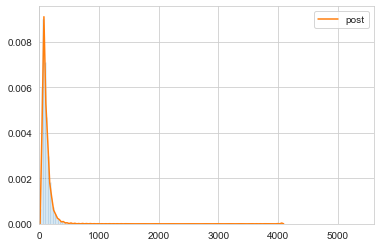

In [402]:
plt.hist(nbr_mots, alpha=0.3, range=(
    0, 5600),  bins=200, density=True)
sns.kdeplot(nbr_mots)

plt.xlim(0, 5600)
plt.rcParams['figure.figsize'] = (20, 20)

In [403]:
y_train_clean.head()

8950                        r dplyr lapply purrr
38421                    python for-loop tabular
19363    json angular typescript asp.net-web-api
30157                              php wordpress
14294    python-3.x pandas dataframe correlation
Name: tags, dtype: object

In [404]:
nbr_tags = y_train_clean.apply(lambda row : len(row.split()))

In [405]:
nbr_tags.describe()

count    35000.000000
mean         2.898086
std          1.212211
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: tags, dtype: float64

Le nombre de tags varie de 1 à 6 avec la valeurs médiane de 3 tags par post.

In [406]:
nbr_tags.shape

(35000,)

In [407]:
freq_tags = nbr_tags.value_counts()

In [408]:
freq_tags

3    9928
2    9593
4    6572
1    4590
5    4317
Name: tags, dtype: int64

In [412]:
freq_tags.sort_index()

1    4590
2    9593
3    9928
4    6572
5    4317
Name: tags, dtype: int64

<Figure size 1440x1440 with 0 Axes>

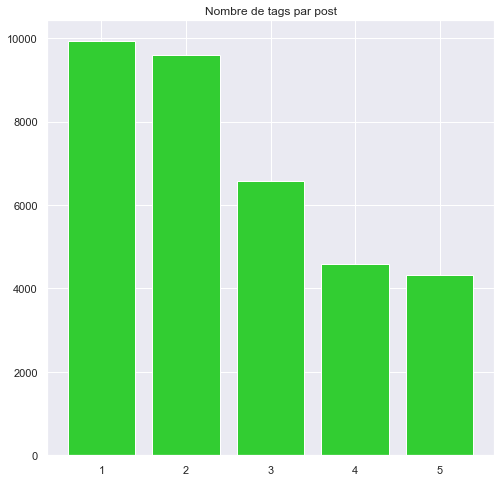

In [475]:
plt.figure()
fig = plt.figure(figsize=(8, 8))
plt.title('Nombre de tags par post')
plt.bar(range(1,6), freq_tags, color='limegreen')
plt.xticks(range(1,6), range(1,6))
plt.show()

## Fréquences des expressions

### Bag of words

#### Feature

Nous allons afficher les fréquences de 50 features les plus utilisées :

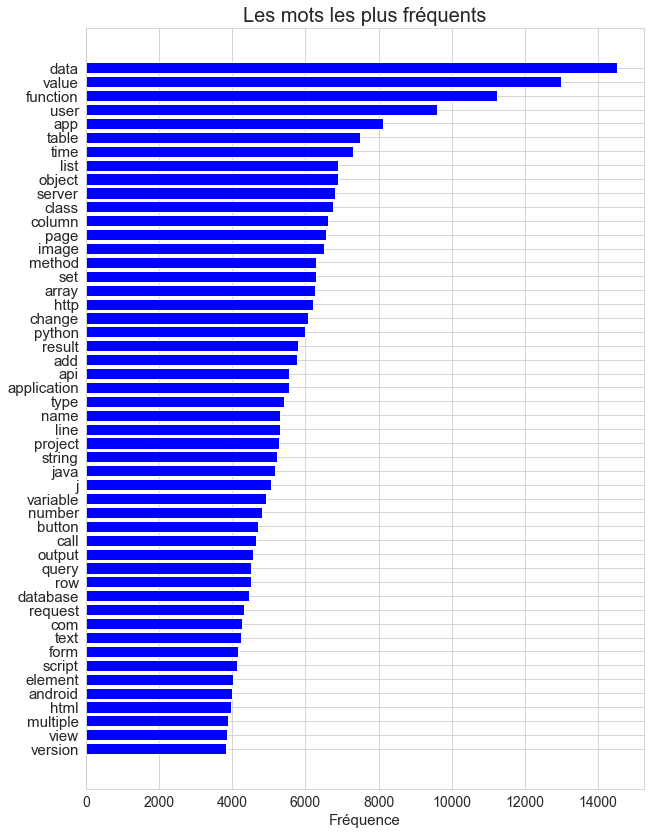

In [416]:
freq_features_50 = freq_features_bow[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

#### Cible

Afin de connaître le nombre total d'expressions utilisées en guise de tags, nous allons refaire BOW sans limiter le nombre maximal de feaures : 

In [181]:
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tag_count_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = None,
                             lowercase=False,
                             stop_words = stop_words) 

Creating the bag of words...



In [183]:
nbr_tags_bow = tag_count_vectorizer.fit_transform(y_train_clean)

In [184]:
nbr_tags_bow.shape

(35000, 11490)

In [185]:
# Creating tag's vocabulary
y_all_vocab_bow = tag_count_vectorizer.get_feature_names()

In [186]:
# Sum up the counts of each vocabulary word
y_all_dist_bow = np.sum(nbr_tags_bow, axis=0)

In [187]:
freq_all_tags_bow = DataFrame(zip(y_train_vocab_bow, y_train_dist_bow))
freq_all_tags_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_all_tags_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_all_tags_bow['Pourcentage'] = round(freq_all_tags_bow['Frequence']*100/sum(freq_all_tags_bow['Frequence']),2)
freq_all_tags_bow[:50]

,Word,Frequence,Pourcentage
3511,python,3777,4.02
2136,javascript,3632,3.87
2113,java,2548,2.71
816,c#,1927,2.05
164,android,1905,2.03
3258,php,1662,1.77
1937,html,1328,1.41
3516,python-3.x,1085,1.16
3673,reactjs,1037,1.10
2936,node.js,1021,1.09


Faisons le même affichage pour les tags.

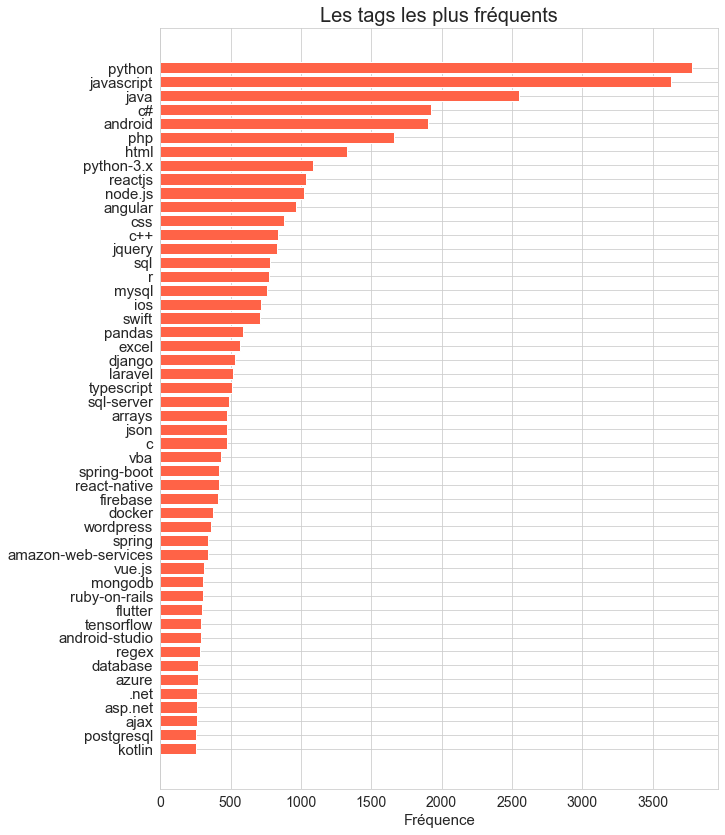

In [417]:
freq_target_50 = freq_all_tags_bow[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='tomato', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

Nous allons afficher les expressions les plus courantes avec leur pourcentage cumulé :

In [190]:
freq_all_tags_bow['Pourc cum'] = freq_all_tags_bow['Pourcentage'].cumsum()
freq_all_tags_bow.head()

,Word,Frequence,Pourcentage,Pourc cum
3511,python,3777,4.02,4.02
2136,javascript,3632,3.87,7.89
2113,java,2548,2.71,10.60
816,c#,1927,2.05,12.65
164,android,1905,2.03,14.68


La première expression est présente 3777 fois, ce qui représente 4 % de posts.

In [191]:
freq_all_tags_bow.tail()

,Word,Frequence,Pourcentage,Pourc cum
413,appsettings,2,0.0,95.8
414,appsflyer,2,0.0,95.8
415,appveyor,2,0.0,95.8
848,callgrind,2,0.0,95.8
313,angular-ng-if,2,0.0,95.8


Les dernières expressions sont présentes seulement 2 fois.

In [156]:
freq_target_bow.shape

(5000, 4)

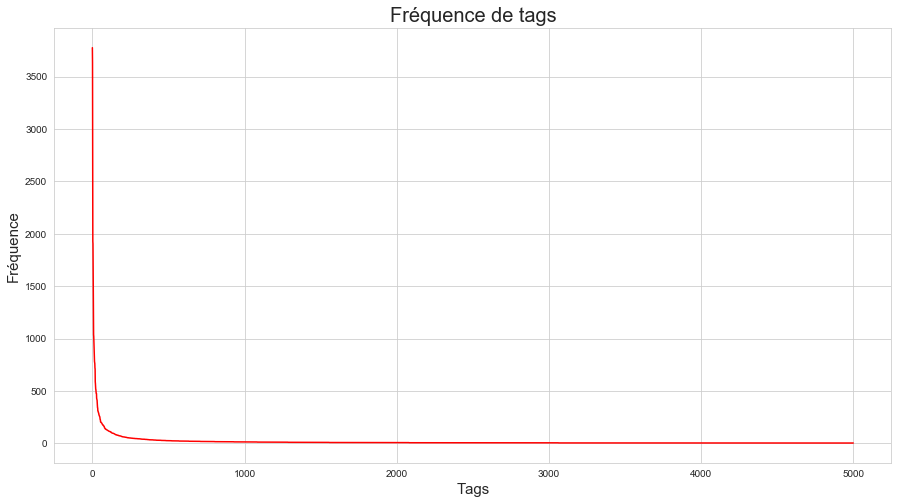

In [421]:
# Plot the frequency of tags        
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Tags', fontsize=15)
#ax.set_xticks(k)
#ax.set_xticklabels(k)
ax.set_ylabel('Fréquence', fontsize=15)
ax.set_title('Fréquence de tags', fontsize=20)

plt.plot(range(freq_target_bow.shape[0]), freq_target_bow['Frequence'], color="red")

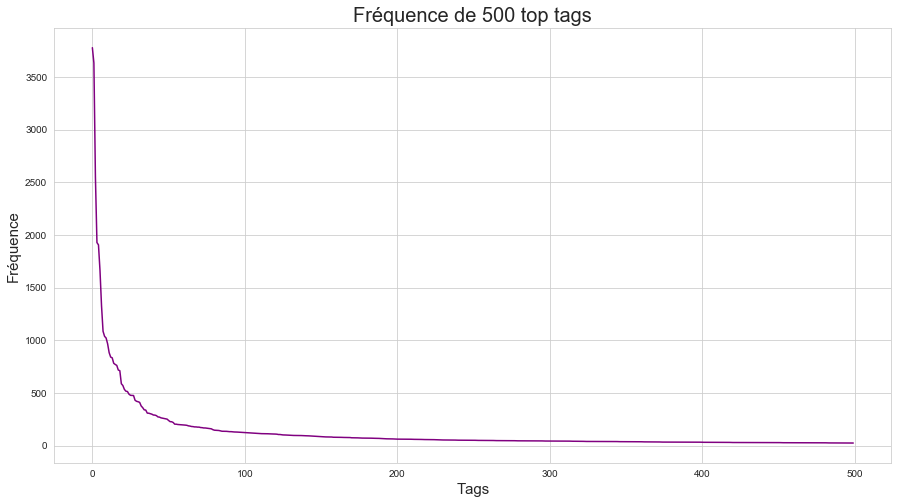

In [422]:
# Plot the frequency of most pfrequent tags        
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Tags', fontsize=15)
#ax.set_xticks(k)
#ax.set_xticklabels(k)
ax.set_ylabel('Fréquence', fontsize=15)
ax.set_title('Fréquence de 500 top tags', fontsize=20)

plt.plot(range(500), freq_target_bow['Frequence'][:500], color="purple")

#### Recodage de cible basé sur analyse exploratoire

Nous avons presque 10k cibles distinctes. Si nous souhaitons prendre tous les tags, nous aurons une matrice de cibles avec 10k colonnes. La dimension de données est immense, ce qui peut être bloquant au niveau de temps de calcul, ainsi que au niveau de précision de prédiction. Nous allons donc utiliser seulement un sous-ensemble de tags les plus courants. 

Dans un premier temps, nous nous limitons au tags qui sont présent dans plus de 0.1 % de cas :

In [66]:
# How many tags are present in more than 0.1 % de cases ?
tags0p1 = freq_target_bow[freq_target_bow['Pourcentage']>0.1]

In [67]:
tags0p1.shape

(122, 3)

Nous obtenons 122 tags.

In [68]:
# Create a function to reduce the tags (keep only top words with frequence >0.1)

top_tags = list(tags0p1["Word"])



def reduce_tags(y):
    
    #new_tags = []
    
    tag = y.split()
    tag = [word for word in tag if word in top_tags]
    
        
    #new_tags.append(tag)
        
    return " ".join(tag)
    

In [69]:
y_train_top_tags = y_train_clean.apply(lambda x : reduce_tags(x))

In [70]:
# Create BOW of recoded target 
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tag_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features=None,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

y_train_0p1_bow = tag_vectorizer.fit_transform(y_train_top_tags)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_0p1_bow = y_train_0p1_bow.toarray()

Creating the bag of words...



In [71]:
y_train_top_tags[:10]

8950                               r
38421                         python
19363        json angular typescript
30157                  php wordpress
14294    python-3.x pandas dataframe
33251           html ionic-framework
43221                            sql
3496                                
45197                         django
38356                         docker
Name: tags, dtype: object

In [72]:
y_train_0p1_bow.shape

(35000, 122)

In [73]:
# Creating tag's vocabulary
y_train_0p1_vocab_bow = tag_vectorizer.get_feature_names()

In [74]:
# Sum up the counts of each vocabulary word
y_train_0p1_dist_bow = np.sum(y_train_0p1_bow, axis=0)

In [75]:
len(y_train_0p1_dist_bow)

122

In [76]:
# Sum up the counts of each post
y_train_0p1_ntags_bow = np.sum(y_train_0p1_bow, axis=1)

In [77]:
len(y_train_0p1_ntags_bow)

35000

In [78]:
Series(y_train_0p1_ntags_bow).value_counts()

1    14620
2    10403
0     5587
3     3472
4      811
5      107
dtype: int64

In [79]:
5164/35000

0.14754285714285714

15 % de questions se retrouvent sans tag, ce qui est acceptable.

In [80]:
freq_top_target_bow = DataFrame(zip(y_train_0p1_vocab_bow, y_train_0p1_dist_bow))
freq_top_target_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_top_target_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_top_target_bow['Pourcentage'] = round(freq_top_target_bow['Frequence']*100/sum(freq_top_target_bow['Frequence']),2)
freq_top_target_bow[:50]

,Word,Frequence,Pourcentage
80,python,3777,7.61
51,javascript,3632,7.32
50,java,2548,5.13
21,c#,1927,3.88
5,android,1905,3.84
77,php,1662,3.35
45,html,1328,2.68
82,python-3.x,1085,2.19
85,reactjs,1037,2.09
71,node.js,1021,2.06


#### Sauvegarder les données

In [100]:
np.save('Data/y_train_0p1_bow', y_train_0p1_bow)
np.save('Data/y_train_0p1_vocab_bow', y_train_0p1_vocab_bow)
np.save('Data/y_train_0p1_dist_bow', y_train_0p1_dist_bow)

### TF-IDF

Pour pouvoir faire comparaison, nous allons aussi afficher les mot les plus fréquentes en se basant sur les fréquences relatives TF-IDF :

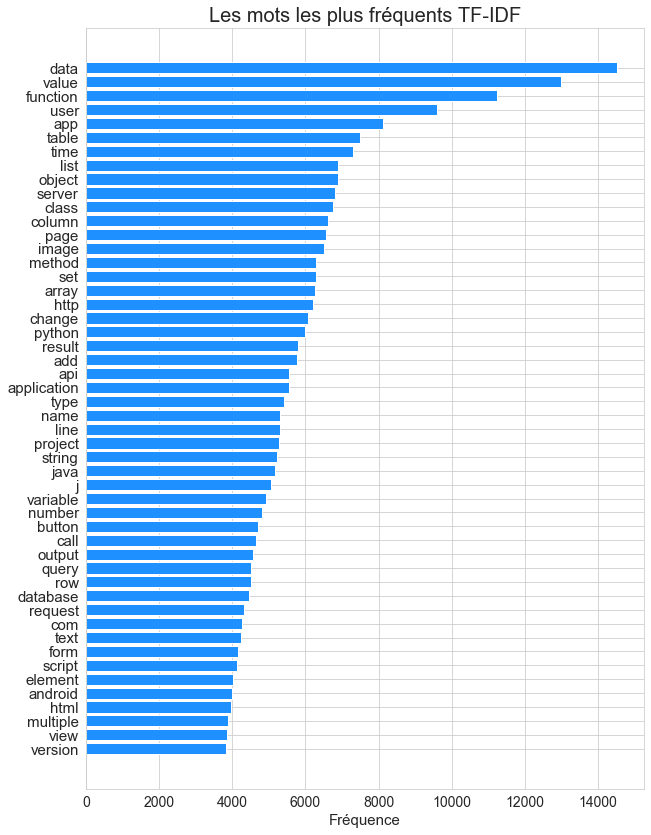

In [441]:
freq_features_50 = freq_features_tfidf[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='dodgerblue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

Affichons également un graphique de tags :

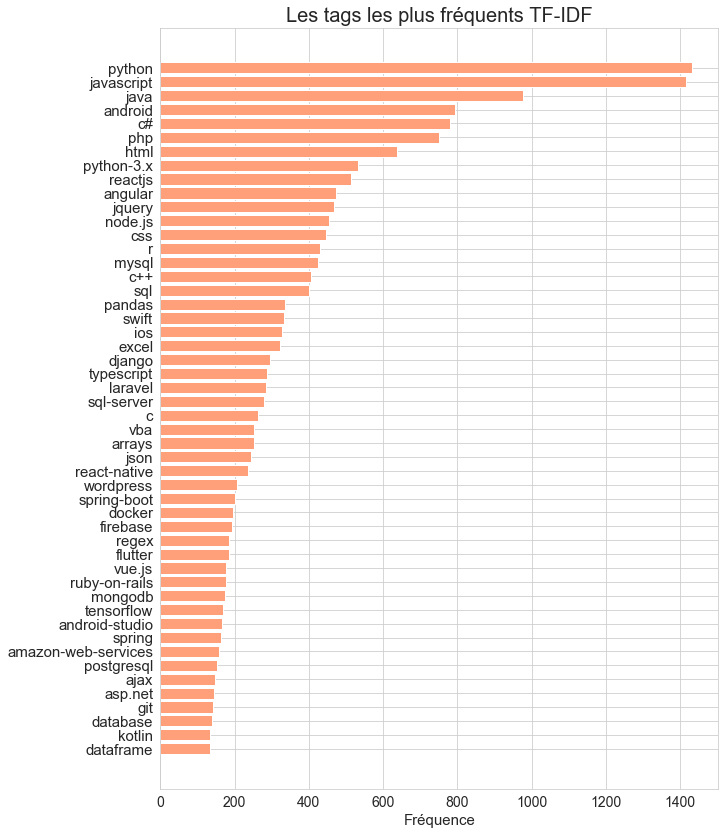

In [442]:
freq_target_50 = freq_target_tfidf[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='lightsalmon', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

Nous constatons seulement légères différences par rapport à la méthode bag of words.

## Réduction de dimension

### Analyse en composantes principales

Nous allons effectuer une analyse en composante principales afin de visualiser les données. L'ACP va être performée sur les données transformées par TF-IDF.

Nous avons 25000 posts, le calcul de ACP est donc assez exigeant sur une matrice 25 000 x 5 000.

Nous allons utiliser un échantillon de 500 premiers posts qui représentent 2% de données. 

#### Création d'échantillon

In [443]:
X_train_tfidf_sample = X_train_tfidf[:1000]

Afin de pouvoir afficher des tags qui nous intéressent, nous allons aussi échantilloner les tags cleanés correspondants.

In [444]:
y_train_clean_sample = y_train_clean[:1000].reset_index(drop=True)

#### Créer le modèle

In [478]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_tfidf_sample)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])

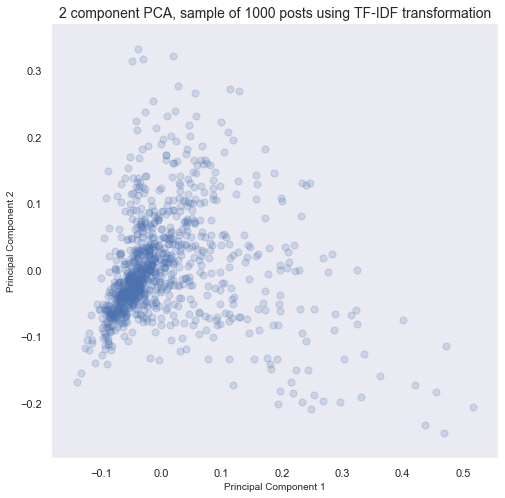

In [479]:
# Scatterplot of all sample posts
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component PCA, sample of 1000 posts using TF-IDF transformation', fontsize=14)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

####  Affichage de groupes de tags

Nous allons choisir 12 tags à afficher - essayeons de prendre 4 groupes de 3 tags avec des sujets qui sont similaire dans chaque groupe. Afin de trouver la position des tags, nous allons construire une fonction qui renvoi un échantillon de n indexes des expressions qui contient un mot donné. 

In [480]:
def choose_expression(ser, word, n=3):

    """Function which returns a list of n random index positions of an expression containing indicated string

    Inputs:

    - ser : a serie of expressions
    - word : a string to search for
    - n : number of returned positions (n=3 by default)

    Output:

    - a list of n positions
    """

    index_list = []

    for i in range(len(ser)):
        if word in ser[i]:
            index = i
            index_list.append(index)
        else:
            pass

    random.seed = 1
    
    index_list = random.sample(index_list, n)
    
    return index_list

In [481]:
# Create the first list of positions containing the word "javascript"
liste_javascript = choose_expression(y_train_clean_sample, 'javascript')
liste_javascript

[561, 201, 478]

In [482]:
# Check
print(y_train_clean_sample[liste_javascript[0]])
print(y_train_clean_sample[liste_javascript[1]])
print(y_train_clean_sample[liste_javascript[2]])

javascript reactjs electron
javascript constants vuex
javascript php html iframe


In [483]:
# Create other lists containing "python", "git" and "android"
liste_python = choose_expression(y_train_clean_sample, 'python')
liste_git = choose_expression(y_train_clean_sample, 'github')
liste_android = choose_expression(y_train_clean_sample, 'php')

In [484]:
# Create an overall list
chosen_tags_index = liste_javascript + liste_python + liste_git + liste_android

In [485]:
chosen_tags_index

[561, 201, 478, 259, 978, 158, 889, 42, 615, 115, 383, 45]

In [486]:
# View the chosen tags
chosen_tags = y_train_clean_sample[chosen_tags_index] 
chosen_tags

561                 javascript reactjs electron
201                   javascript constants vuex
478                  javascript php html iframe
259    python graph networkx gephi social-graph
978                       python tensorflow gpu
158                                  python-3.x
889                                      github
42                             xcode github ssh
615                              git github-api
115               php function switch-statement
383                               php wordpress
45                                    php mysql
Name: tags, dtype: object

In [487]:
chosen_principalDf = principalDf.iloc[chosen_tags_index]
chosen_principalDf

,principal component 1,principal component 2
561,-0.044079,-0.065725
201,-0.011681,0.030601
478,-0.036307,-0.018945
259,0.123668,0.113807
978,-0.034291,-0.017991
158,0.014995,0.065069
889,-0.048368,-0.051746
42,-0.049839,-0.021320
615,0.005092,-0.024349
115,-0.016544,0.105084


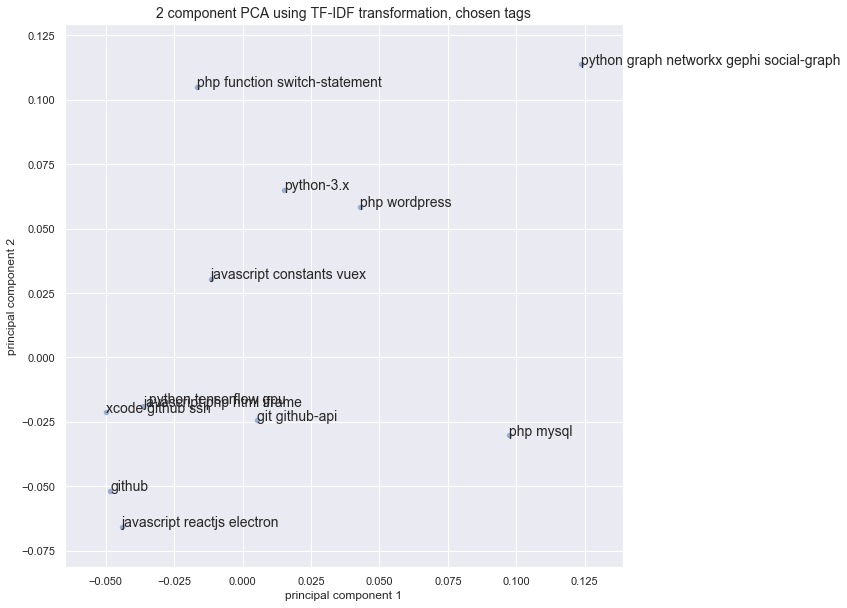

In [488]:
# Scatterplot of chosen tags

sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (10, 10))

ax.set_title('2 component PCA using TF-IDF transformation, chosen tags', fontsize=14)

sns.scatterplot(chosen_principalDf['principal component 1'],
           chosen_principalDf['principal component 2'], alpha = 0.5)
 
for i in chosen_tags.index:    
    
    plt.text(chosen_principalDf['principal component 1'][i], chosen_principalDf['principal component 2'][i], 
             chosen_tags[i],fontsize = 14)

plt.show()

Nous pouvons voir que les point représentants des posts sont proches selon le groupe - les tags contenant "python" sont en haut à gauche, "git"s sont en haut à droite, "javascript" se mélange un peu avec "android", mais les groupes sont quand même séparables. 

### t-SNE 

#### Créer le modèle

In [489]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

In [490]:
tsne_df = tsne.fit_transform(X_train_tfidf_sample)

In [491]:
principalDf = pd.DataFrame(data=tsne_df, columns=[
                           'principal component 1', 'principal component 2'])

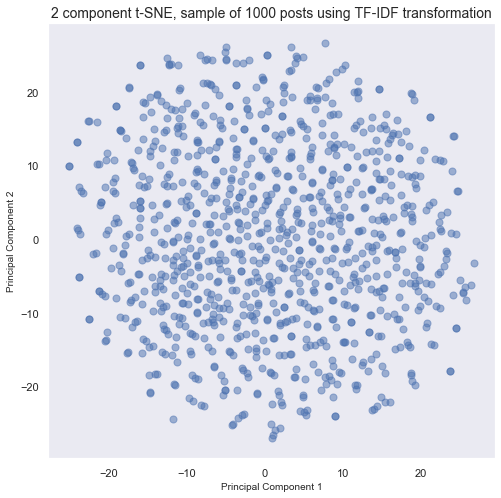

In [492]:
# Scatterplot of all sample posts
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component t-SNE, sample of 1000 posts using TF-IDF transformation', fontsize=14)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.5)
ax.grid()

Le nuage de points créé à l'aide de t-SNE semble former un rond.

#### Affichage de groupes de tags

In [493]:
chosen_principalDf = principalDf.iloc[chosen_tags_index]

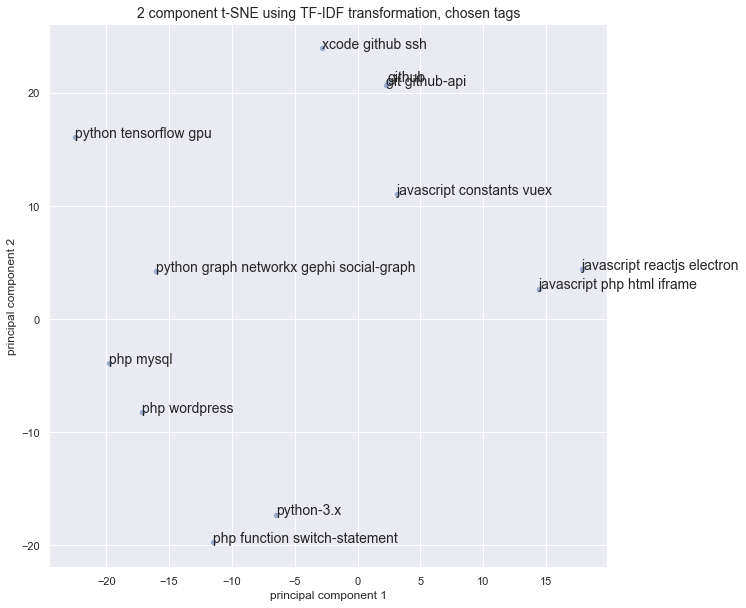

In [494]:
# Scatterplot of chosen tags

sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (10, 10))

ax.set_title('2 component t-SNE using TF-IDF transformation, chosen tags', fontsize=14)

sns.scatterplot(chosen_principalDf['principal component 1'],
           chosen_principalDf['principal component 2'], alpha = 0.5)
 
for i in chosen_tags.index:    
    
    plt.text(chosen_principalDf['principal component 1'][i], chosen_principalDf['principal component 2'][i], 
             chosen_tags[i],fontsize = 14)

plt.show()

Nous pouvons trouver certains tags avec la même thématique proche les uns des autres (git, python), mais la séparation n'est pas très prononcée.

# Traitement de données pour le modèle final

Dans la partie précédente, nous avons utilisé une transformation de données BOW et TF-IDF en limitant le maximum de features à 5000. Nous avons ainsi créé des matrices avec 5000 colonnes représentantes chaqu'une un mot de corpus. En réalité, notre corpus contient beaucoup plus de mots. 

Etant donné que nous ne pouvons pas connaître en avance combien de mots nous allons avoir dans le corpus de données test, ni si c'est mots seront les mêmes comme dans le corpus de données d'entraînement, il n'est pas approprié de limiter le maximum de features qui est malgré tout utile pour augmenter la rapidité de traitement de données.

Nous allons donc créer des nouvelles matrices TF-IDF de données d'entraînement et de test en utilisant TfidfVectorizer sans limitation de nombre maximale de features.

## Données d'entraînement

### Features

In [6]:
print ("Creating the TF - IDF...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.  
tf_idf_final = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = None, 
                             lowercase=False,
                             stop_words = stop_words)       

Creating the TF - IDF...



In [ ]:
X_train_final = tf_idf_final.transform(X_train['post_w'])

X_train_final = X_train.toarray()

## Données de test

## Feature

In [82]:
X_test['body_clean']=X_test['body'].apply(lambda x: post_to_words(x))

In [83]:
X_test['title_clean']=X_test['title'].apply(lambda x: post_to_words(x))

In [84]:
X_test['post_w'] = (X_test['title_clean'] + " ") *3 + " " + X_test['body_clean']

In [86]:
X_test_final = tf_idf_final.transform(X_test['post_w'])

X_test_final = X_test_final.toarray()

In [87]:
# !!! Nécessité ?
# Create a vocabulary of features
#X_test_final_vocab = tf_idf_final.get_feature_names()

In [88]:
# !!! Nécessité ?
# Sum up the counts of each vocabulary word
#X_test_final_dist = np.sum(X_test_final, axis=0)

## Target

In [90]:
y_test_clean=y_test.apply(lambda x: cleaning_target(x))

In [91]:
y_test_top_tags = y_test_clean.apply(lambda x : reduce_tags(x))

In [92]:
y_test_0p1_bow = tag_vectorizer.fit_transform(y_test_top_tags) 

# Numpy arrays are easy to work with, so convert the result to an array
y_test_0p1_bow = y_test_0p1_bow.toarray()

In [94]:
# !!! Nécessité ?
# Creating tag's vocabulary
#y_test_0p1_vocab_bow = tag_vectorizer.get_feature_names()

In [95]:
# !!! Nécessité ?
# Sum up the counts of each vocabulary word
#y_test_0p1_dist_bow = np.sum(y_test_0p1_bow, axis=0)

## Sauvegarder les données

In [32]:
np.save('Data/X_test_final', X_test_final)
#np.save('Data/X_test_final_vocab', X_test_final_vocab)
#np.save('Data/X_test_final_dist', X_test_final_dist)

In [ ]:
np.save('Data/X_train_final', X_train_final)
#np.save('Data/X_train_final_vocab', X_train_final_vocab)
#np.save('Data/X_train_final_dist', X_train_final_dist)

In [98]:
np.save('Data/y_test_0p1_bow', y_test_0p1_bow)
#np.save('Data/y_test_0p1_vocab_bow', y_test_0p1_vocab_bow)
#np.save('Data/y_test_0p1_dist_bow', y_test_0p1_dist_bow)